In [1]:
#Standard fastai imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
np.random.seed(11)

In [2]:
#Assigning a path makes it easier when working on other machines with different data locations
path = Path('data')

In [3]:
df = pd.read_csv(path/'full.csv')
path_img = path/'ISIC_2019_Training_Input'

In [4]:
#Add flip vert in addition to standard fastai transforms
tfms = get_transforms(flip_vert=True)

Here it may be okay to add flip_vert to the standard transforms. We want to be able to diagnose images from any angle.

In [5]:
#Grab the train/val indexs
train_idx = df[df['is_val']==0].index
val_idx = df[df['is_val']==1].index

Next we are going to create our databunch. First we will train on smaller image sizes so we can reduce training time. Later we can retrain the same model on larger image sizes. (Note: You may need to use a smaller batch size depending on your gpu memory)

In [6]:
#Create the data source
src = (ImageList.from_csv(path_img, '../full.csv',suffix='.jpg')
                .split_by_idxs(train_idx,val_idx)
                .label_from_df(cols=1))

#Create databunch
data = (src.transform(tfms, size=128)
            .databunch(bs=256)).normalize(imagenet_stats)

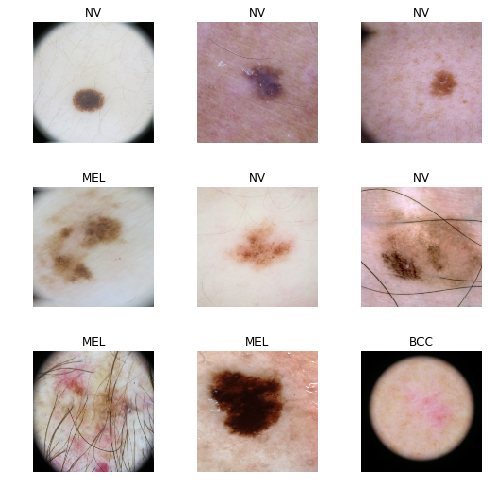

In [7]:
data.show_batch(3, figsize=(7,7))

In [8]:
#Add metrics out of my own curiosity
top_2 = partial(top_k_accuracy, k=2)
top_3 = partial(top_k_accuracy, k=3)

In [9]:
#weight decay will help with regularization
#to_fp16 will perform some operations in fp16 instead of 32. Lets model use less memory
learn = cnn_learner(data, models.resnet50,
                    metrics=[error_rate, top_2, top_3], wd=1e-1).to_fp16()

When we train our models in this notebook we will use Lesie Smith's one cycle learning. This helps our model train even faster and take a lot of the guess work out of finding optimal learning rates. This method allows us to find ideal learning rates based on the plot below. There is a suggested learning rate feature, but its worth experimenting with different learning rates on your own.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


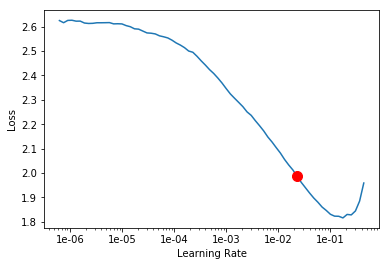

In [10]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [11]:
lr = 1e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,error_rate,top_k_accuracy,top_k_accuracy,time
0,1.193867,0.935594,0.332496,0.846867,0.927438,02:00
1,0.928982,0.880279,0.322130,0.850950,0.928538,01:57
2,0.825117,0.903878,0.325271,0.842469,0.926810,01:58
3,0.736383,0.761215,0.277525,0.883776,0.948013,01:57
4,0.661577,0.745000,0.266216,0.891315,0.946600,01:56


In [12]:
learn.save('res50-1-sz128')

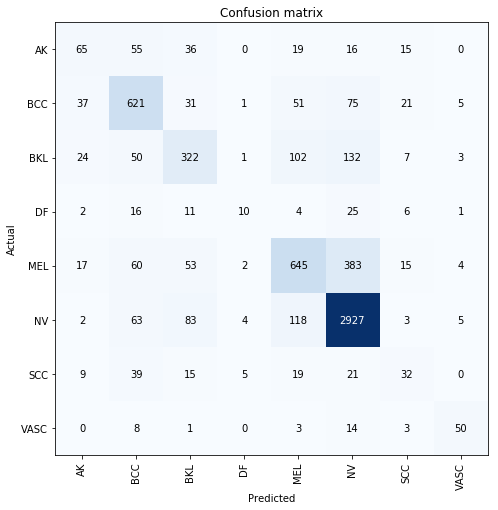

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,7))

In [14]:
learn.load('res50-1-sz128')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


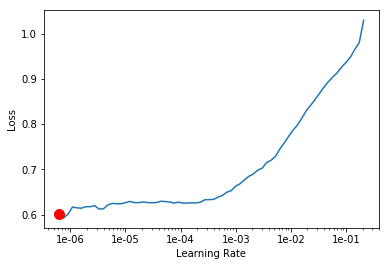

In [16]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
#Max_lr=slice() lets us use discriminative learning rates,
#The earlier layers will have much lower learning rates
learn.fit_one_cycle(5, max_lr=slice(1e-6,lr/5))

In [ ]:
learn.save('res50-2-sz128')

In [ ]:
#interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
#interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
# learn.to_fp32()

# interp = ClassificationInterpretation.from_learner(learn)

# interp.plot_top_losses(9, figsize=(9,9),heatmap=False)

In [ ]:
data = (src.transform(tfms, size=299)
            .databunch(bs=16)).normalize(imagenet_stats)

In [ ]:
data.show_batch()

In [ ]:
learn = cnn_learner(data, models.densenet161,
                     metrics=[error_rate, top_2, top_3], wd=1e-1).to_fp16()

In [ ]:
learn.load('dense161-1-128')
learn.freeze()
gc.collect()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 3e-5
learn.fit_one_cycle(5, lr)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
learn.save('dense161-1-299')